In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#read excel file with columns to be used
df = pd.read_excel('Solaranlage_2020.xlsx', 
                    skiprows=3, usecols=['### UNIX-Zeitstempel',' Entladung(Wh)', ' Ladung(Wh)',
       ' Erzeugung(Wh)', ' Verbrauch(Wh)', ' Netz-Einspeisung(Wh)',
       ' Netz-Bezug(Wh)'], index_col='### UNIX-Zeitstempel')  
#rename columns without leading whitespace
original_columns = list(df.columns)
new_cols = []
for col in original_columns:
    new_cols.append(col.strip())
#create dict to rename cols
col_dict = dict(zip(original_columns, new_cols))
#set index as datetime 
df.index = pd.to_datetime(df.index, unit='s', utc=True).map(lambda x: x.tz_convert('Europe/Berlin'))
df.index.rename('Datum',inplace=True)
df.rename(columns=col_dict, inplace=True)
df.sort_index(inplace=True,)                  
df.head()


,Entladung(Wh),Ladung(Wh),Erzeugung(Wh),Verbrauch(Wh),Netz-Einspeisung(Wh),Netz-Bezug(Wh)
Datum,,,,,,
2020-10-27 14:25:00+01:00,0.0,0.0,0.0,30.38,0.0,30.38
2020-10-27 14:30:00+01:00,0.0,0.0,0.0,30.43,0.0,30.43
2020-10-27 14:35:00+01:00,0.0,0.0,0.0,27.84,0.0,27.84
2020-10-27 14:40:00+01:00,0.0,0.0,0.0,29.02,0.0,29.02
2020-10-27 14:45:00+01:00,0.0,0.0,0.0,28.39,0.0,28.39


In [4]:
daily_df = df.resample('D').sum()
daily_df['total_verbrauch'] = daily_df['Erzeugung(Wh)'] - daily_df['Verbrauch(Wh)']
daily_df['netz_leistung'] = daily_df['Netz-Einspeisung(Wh)'] - daily_df['Netz-Bezug(Wh)']
daily_df.head()


,Entladung(Wh),Ladung(Wh),Erzeugung(Wh),Verbrauch(Wh),Netz-Einspeisung(Wh),Netz-Bezug(Wh),total_verbrauch,netz_leistung
Datum,,,,,,,,
2020-10-27 00:00:00+01:00,0.0,0.0,159.51,3955.69,10.14,3806.32,-3796.18,-3796.18
2020-10-28 00:00:00+01:00,0.0,0.0,10847.64,9533.65,6476.88,5162.89,1313.99,1313.99
2020-10-29 00:00:00+01:00,0.0,0.0,7715.79,6812.82,4903.77,4000.80,902.97,902.97
2020-10-30 00:00:00+01:00,0.0,0.0,6074.49,7005.03,3543.43,4473.97,-930.54,-930.54
2020-10-31 00:00:00+01:00,0.0,0.0,17917.41,6892.30,14201.02,3175.91,11025.11,11025.11


In [5]:
monthly_df = df.resample('M').sum()
monthly_df['total_verbrauch'] = monthly_df['Erzeugung(Wh)'] - monthly_df['Verbrauch(Wh)']
monthly_df['netz_leistung'] = monthly_df['Netz-Einspeisung(Wh)'] - monthly_df['Netz-Bezug(Wh)']
monthly_df.head(12)

,Entladung(Wh),Ladung(Wh),Erzeugung(Wh),Verbrauch(Wh),Netz-Einspeisung(Wh),Netz-Bezug(Wh),total_verbrauch,netz_leistung
Datum,,,,,,,,
2020-10-31 00:00:00+01:00,0.00,0.00,42714.84,34199.49,29135.24,20619.89,8515.35,8515.35
2020-11-30 00:00:00+01:00,93290.19,123289.52,300909.67,219167.27,105379.15,53730.19,81742.40,51648.96
2020-12-31 00:00:00+01:00,49397.38,69499.27,132026.92,249621.55,8679.99,146411.16,-117594.63,-137731.17


In [6]:
df.groupby(df.index.month).sum()

,Entladung(Wh),Ladung(Wh),Erzeugung(Wh),Verbrauch(Wh),Netz-Einspeisung(Wh),Netz-Bezug(Wh)
Datum,,,,,,
10,0.00,0.00,42714.84,34199.49,29135.24,20619.89
11,93290.19,123289.52,300909.67,219167.27,105379.15,53730.19
12,49397.38,69499.27,132026.92,249621.55,8679.99,146411.16


In [16]:
#pick a random single day from df
day = df['2020-11-11':'2020-11-11']

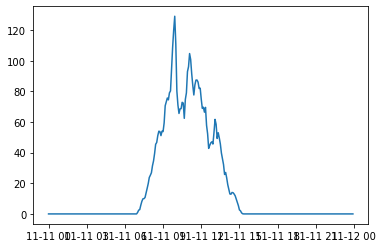

In [18]:
fig, ax = plt.subplots()
ax.plot(day.index, day['Erzeugung(Wh)'], label='Erzeugung')

In [65]:
df.head()

,Entladung(Wh),Ladung(Wh),Erzeugung(Wh),Verbrauch(Wh),Netz-Einspeisung(Wh),Netz-Bezug(Wh)
Datum,,,,,,
2020-10-27 14:25:00,0.0,0.0,0.0,30.38,0.0,30.38
2020-10-27 14:30:00,0.0,0.0,0.0,30.43,0.0,30.43
2020-10-27 14:35:00,0.0,0.0,0.0,27.84,0.0,27.84
2020-10-27 14:40:00,0.0,0.0,0.0,29.02,0.0,29.02
2020-10-27 14:45:00,0.0,0.0,0.0,28.39,0.0,28.39
